# Topic Modeling and Document Clustering

Examples of unsupervised learning on documents. 

In [1]:
# add scripts/ folder to path
import os, sys

SCRIPTS_PATH = os.environ['DSX_PROJECT_DIR'] + '/scripts'
sys.path.insert(0, SCRIPTS_PATH)

In [2]:
# sys.path.insert(0, '../scripts')

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import visualization # custom script

In [4]:
DATASET_PATH = "/user-home/libraries/text-analytics/datasets/aclImdb"
TRAIN_PATH = DATASET_PATH + "/train/"
TEST_PATH = DATASET_PATH + "/test/"

In [5]:
# DATASET_PATH = "../datasets/aclImdb"
# TRAIN_PATH = DATASET_PATH + "/train/"
# TEST_PATH = DATASET_PATH + "/test/"

## 0. Load files

In [6]:
from sklearn.datasets import load_files

We only load the training data, without labels, and consider it as unlabeled data:

In [7]:
reviews_train = load_files(TRAIN_PATH)
text_train = reviews_train.data
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))

type of text_train: <class 'list'>
length of text_train: 25000


## 1. Preprocessing

Even though the preprocessing is short and straightforward, we probably want to move this to a script at some point.

In [8]:
text_train = [doc.replace(b"<br />", b" ").decode('utf-8') for doc in text_train]

In [9]:
text_train = pd.DataFrame({"review": text_train, "sentiment": reviews_train.target})

## 2. Feature Engineering

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

We limit the number of features to speed up the topic modeling.

In [11]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X_train = vect.fit_transform(text_train.review)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 1948677 stored elements in Compressed Sparse Row format>


In [12]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 10000
First 20 features:
['00', '000', '10', '100', '1000', '101', '11', '12', '13', '13th', '14', '15', '150', '16', '17', '18', '18th', '19', '1920', '1920s']
Features 20010 to 20030:
[]
Every 2000th feature:
['00', 'conroy', 'graphic', 'named', 'sharp']


## 3. Build model

### 3.1 Latent Dirichlet Allocation (LDA), 10 topics

Training LDA on the full data is very slow, and training it on a subset of the data gives "bad" topics: instead, we only perform NMF -> see section 3.2

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

In [14]:
# %%time
# lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
#                                 max_iter=25, random_state=0)
# document_topics = lda.fit_transform(X_train)
# print("lda.components_.shape: {}".format(lda.components_.shape))

In [15]:
# # for each topic (a row in the components_), sort the features (ascending).
# # Invert rows with [:, ::-1] to make sorting descending
# sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# # get the feature names from the vectorizer:
# feature_names = np.array(vect.get_feature_names())

#### Explore the topics:

In [16]:
# # Print out the 10 topics:
# visualization.print_topics(topics=range(10), feature_names=feature_names,
#                            sorting=sorting, topics_per_chunk=5, n_words=10)

### 3.2 Non-Negative Matrix Factorization (NMF), 10 topics

In [14]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import FunctionTransformer

**With pipe:**

In [17]:
pipe = make_pipeline(FunctionTransformer(pd.DataFrame.get, kw_args={'key':'review'}, validate=False),
                     CountVectorizer(max_features=10000, max_df=.15),
                     NMF(n_components=10, max_iter=25, random_state=0))
nmf = pipe.steps[2][1]
vect = pipe.steps[1][1]

In [18]:
%%time
document_topics_nmf = pipe.fit_transform(text_train)
print("nmf.components_.shape: {}".format(nmf.components_.shape))

nmf.components_.shape: (10, 10000)
CPU times: user 10.5 s, sys: 10.3 s, total: 20.9 s
Wall time: 9.16 s


#### Explore the topics

In [20]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_nmf = np.argsort(nmf.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

In [21]:
# Print out the 10 topics:
visualization.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting_nmf, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
director      show          re            series        horror        
work          shows         thing         original      house         
role          episode       nothing       episode       gore          
performance   tv            didn          new           blood         
quite         season        going         episodes      zombie        
cast          episodes      guy           tv            effects       
though        television    actually      season        budget        
actors        funny         doesn         years         dead          
however       always        minutes       batman        scary         
both          real          want          star          killer        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
us  

From these topic descriptions, the NMF was able to pick up on a few obvious trends given these parameters. First, Topic 4 seems to encompass reviews on horror movies. Below we print snippets from the most important reviews in the horror category. Modify the ```num_doc``` variable to preview more samples.

In [22]:
# sort by weight of "Horror" topic 4
top_horror = np.argsort(document_topics_nmf[:, 4])[::-1]

# print the five documents where the topic is most important
print("Most important reviews in HORROR topic:")
i = 1
num_doc = 5
for idx in top_horror[:num_doc]:
    print("{i}. {text}...\n".format(i=i, text=text_train.at[idx, 'review'][:200])) 
    i += 1

Most important reviews in HORROR topic:
1. Horror omnibus films were popular in the seventies. I'm not very fond of them myself, but this one is an undeniably excellent slice of British horror cinema. The House That Dripped Blood is a horror o...

2. The British production company Amicus is generally known as the specialist for horror anthologies, and this great omnibus called "The House That Dripped Blood" is doubtlessly the finest Amicus product...

3. Four tales of terror regarding the events at a creepy old mansion are recounted to sceptical Scotland Yard investigator Holloway (John Bennett) as he investigates the whereabouts of the latest occupan...

4. There is no doubt that during the decade of the 30s, the names of Boris Karloff and Bela Lugosi became a sure guarantee of excellent performances in high quality horror films. After being Universal's ...

5. I have just recently been through a stage where I wanted to see why it is that horror films of the 90's can't hold a candle t

Similarly, Topic 8 seems to be discussing movies that are adapted from novels. Jane Eyre seemed to bubble up to the top of this topic, with many of the terms highly associated with the topic being directly related to the movie adaptation of the novel (i.e. "jane", "eyre", "dalton", "rochester"). The top 4 reviews are, in fact, about the movie. However, the topic encompasses additional adaptations, in the fifth review disucssing the adaptation of The Robber Bride by Margaret Atwood.

In [23]:
# sort by weight of "Book" topic 8
top_book = np.argsort(document_topics_nmf[:, 8])[::-1]

# print the documents where the topic is most important
print("Most important reviews in BOOK topic:")
i = 1
num_doc = 5
for idx in top_book[:num_doc]:
    print("{i}. {text}...\n".format(i=i, text=text_train.at[idx, 'review'][:200])) 
    i += 1

Most important reviews in BOOK topic:
1. I felt duty bound to watch the 1983 Timothy Dalton / Zelah Clarke adaptation of "Jane Eyre," because I'd just written an article about the 2006 BBC "Jane Eyre" for TheScreamOnline.  So, I approached w...

2. The 1983 BBC production of "Jane Eyre" starring Zelah Clarke and Timothy Dalton (LOVE HIM) has always been and will always be my favorite Jane Eyre. If you watch any other version of Jane Eyre without...

3. There are many adaptations of Charlotte Brontë's classic novel "Jane Eyre", and taking into consideration the numerous reviews written about them there is also a lively discussion on which of them is ...

4. This TV production of 1970 starring Susannah York and George C. Scott is another proof of how difficult it is to adopt "Jane Eyre" to the screen, and how much can go wrong in doing so. It is true that...

5. When I saw that Mary Louise Parker was associated with this epic novel turned film, I was intrigued. Being a fan of the book, I

Below we will investigate the relationship of topic to sentiment. We will accomplish this by plotting an average sentiment for the top 1000 documents. Nearly all the topics have have sentiments above or close to 50% except for Topic 2. This suggests that Topic 2 tends to be associated with negative reviews. 

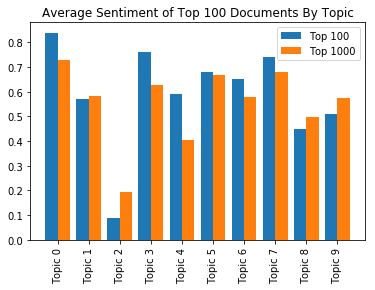

In [24]:
num_doc = 100

importance = np.flip(document_topics_nmf.transpose().argsort(), axis = 1)
sentiment_top = np.array([text_train['sentiment'][row] for row in importance])
topn_topic_sent = np.mean(sentiment_top[:,:num_doc], axis = 1)
top1000_topic_sent = np.mean(sentiment_top[:,:1000], axis = 1)

fig, ax = plt.subplots()
ind = np.arange(10)
plt.bar(ind-.2, topn_topic_sent, width = 0.4, label="Top {num_doc}".format(num_doc=num_doc))
plt.bar(ind+.2, top1000_topic_sent, width = 0.4, label="Top 1000")
plt.title("Average Sentiment of Top {num_doc} Documents By Topic".format(num_doc=num_doc))
plt.xticks(ind, ["Topic {i}".format(i=i) for i in ind], rotation = 'vertical')
ax.legend()
plt.show()

Printing the top documents in Topic 2, we can see that these are scathing reviews... The top words associated with topic 2 don't make that very clear, however. From the printed reviews there seems to be a preference for video game or video game adaptations as well.    

In [25]:
# sort by weight of "RE" topic 2
topic_2 = np.argsort(document_topics_nmf[:, 2])[::-1]

# print the documents where the topic is most important
print("Most important reviews in topic 2:")
i = 1
num_doc = 5
for idx in topic_2[:num_doc]:
    print("{i}. {text}...\n".format(i=i, text=text_train.at[idx, 'review'][:300])) 
    i += 1

Most important reviews in topic 2:
1. ***SPOILERS*** ***SPOILERS*** Continued...  From here on in the whole movie collapses in on itself. First we meet a rogue program with the indication we're gonna get ghosts and vampires and werewolves and the like. We get a guy with a retarded accent talking endless garbage, two 'ghosts' that serve ...

2. Oh Dear Lord, How on Earth was any part of this film ever approved by anyone? It reeks of cheese from start to finish, but it's not even good cheese. It's the scummiest, moldiest, most tasteless cheese there is, and I cannot believe there is anyone out there who actually, truly enjoyed it. Yes, if y...

3. *** Warning - this review contains "plot spoilers," though nothing could "spoil" this movie any more than it already is. It really IS that bad. ***  Before I begin, I'd like to let everyone know that this definitely is one of those so-incredibly-bad-that-you-fall-over-laughing movies. If you're in a...

4. Okay, so I'm not a big video game buff

## 4. Store model

### 4.1 Save model in ML repository

In [26]:
from dsx_ml.ml import save

In [27]:
deployment_info = save(name='simple-topic-modeling',
                        model=pipe,
                        algorithm_type='Classification', # Only classification and regression are supported
                        description='This is the first simple topic modeling with NMF',
                        source='simple-topic-modeling.ipynb')
print(deployment_info)

Using TensorFlow backend.


{'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/scikit-learn-0.19/text-deployment-demo/simple-topic-modeling/2', 'path': '/user-home/1055/DSX_Projects/text-deployment-demo/models/simple-topic-modeling/2'}


### 4.2 Test model in Models UI

The UI doesn't support Unsupervised models with sklearn.

### 4.3 Test model with REST API call

Similarly, we can't directly use the API that's automatically generated for Unsupervised models with sklearn.

### 4.4 Create a custom scoring script

WS Local automatically support only classification and regression models for scikit-learn. Yet, deploying unsupervised models is also very easy and only requires a few steps.

**1. In the "models" section, select the model we just saved, and click on "Generate custom scoring script"**
<img style="float: left;" src="https://i.imgur.com/0LsTt5o.png" alt="Step 1 - Create custom script" width=900 />

**2. This will generate a script with the same functions that are automatically generated when using the raw API/using the UI. Note that doing this is a good way of debugging a deployment that failed, in other cases. By default, the script is set to run as a web service. To debug it, we can set it as a job in the "Run Configuration" panel.**
<img style="float: left;" src="https://i.imgur.com/xi7vF9B.png" alt="Step 2 - Modify custom script: switch to job" width=900 />

**3. To switch from classification to topic modeling, all we need to do is to identify the part where the predict() function is called, and switch it to transform() instead.**
<img style="float: left;" src="https://i.imgur.com/f1A4v5Q.png" alt="Step 3 - Modify custom script: switch to transform()" width=900 />

**4. To try out the code modification, call the test_score() function within the script and print the result. Then save the script and run it. If the console output is hidden, drag it from the right of the screen.**
<img style="float: left;" src="https://i.imgur.com/v4yQHvK.png" alt="Step 3 - Modify custom script: switch to transform()" width=900 />

**5. Once the code is running, switch the "Run configuration" back to "Web Service", save it, and select the run button again. The UI will show the steps necessary to call this newly created API to be able to score the model**
<img style="float: left;" src="https://i.imgur.com/GmmS5kf.png" alt="Step 3 - Modify custom script: switch to transform()" width=900 />